<a href="https://colab.research.google.com/github/kzislam/Transformer-Model/blob/main/Transformer_Model_UHRW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
data = pd.read_excel("/content/Transformer_Data.xlsx", sheet_name='BO')
data.head()

,Date,Tmax,Tmin,RH,P,Q
0,1981-01-01,-3.82,-11.13,99.62,1.67,25.3
1,1981-01-02,-3.63,-9.13,99.88,1.30,24.6
2,1981-01-03,-0.08,-15.46,98.88,8.87,23.9
3,1981-01-04,-10.54,-15.85,98.75,3.00,23.3
4,1981-01-05,-9.57,-16.74,99.50,4.72,23.0


In [4]:
# Load and prepare the dataset
data = data.copy()
dates = data['Date']  # Save dates for plotting purposes

# Define input features and target variable
X_dynamic_features = data[['Tmax', 'Tmin', 'RH', 'P']].values
y_target = data['Q'].values

# Add lagged streamflow (Q) features (lags of 1 to 12 months)
for lag in range(1, 13):
    data[f'Lag_Q_{lag}'] = data['Q'].shift(lag)

# Drop rows with NaN values created by lagging
data = data.dropna()

In [5]:
# Redefine inputs and target to include lagged Q features
X_dynamic_features = data[['Tmax', 'Tmin', 'RH', 'P'] + [f'Lag_Q_{i}' for i in range(1, 13)]].values
y_target = data['Q'].values

In [6]:

# Scale features and target to range [0, 1]
scaler_X = MinMaxScaler()
X_dynamic_scaled = scaler_X.fit_transform(X_dynamic_features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_target.reshape(-1, 1))

# Reshape input data for LSTM layer to 3D format (samples, timesteps, features)
X_dynamic_scaled = X_dynamic_scaled.reshape((X_dynamic_scaled.shape[0], 1, X_dynamic_scaled.shape[1]))

In [7]:
# Split data into training and testing sets (70% training, 30% testing)
train_percentage = 0.7
X_train, X_test, y_train, y_test = train_test_split(
    X_dynamic_scaled, y_scaled, test_size=(1 - train_percentage), random_state=42)

In [8]:
# Define a custom Gated Residual Network (GRN) layer
class GRN(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GRN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units)
        self.gate = tf.keras.layers.Dense(units, activation='sigmoid')
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        gate_output = self.gate(inputs)
        x = gate_output * x
        x = self.layer_norm(x + inputs)
        return x

# Define the Variable Selection Network
class VariableSelectionNetwork(tf.keras.layers.Layer):
    def __init__(self, num_features, num_units):
        super(VariableSelectionNetwork, self).__init__()
        self.grn_layers = [GRN(num_units) for _ in range(num_features)]
        self.selection_layer = tf.keras.layers.Dense(num_features, activation='sigmoid')

    def call(self, inputs):
        feature_outputs = [self.grn_layers[i](inputs[..., i:i + 1]) for i in range(inputs.shape[-1])]
        feature_outputs = tf.stack(feature_outputs, axis=-1)
        selection_weights = self.selection_layer(tf.reduce_mean(feature_outputs, axis=-2))
        selection_weights = tf.expand_dims(selection_weights, axis=-2)
        selected_features = tf.reduce_sum(feature_outputs * selection_weights, axis=-1)
        return selected_features

# Define the Temporal Fusion Transformer (TFT) Model
class TemporalFusionTransformer(tf.keras.Model):
    def __init__(self, num_features, hidden_units):
        super(TemporalFusionTransformer, self).__init__()
        self.variable_selection = VariableSelectionNetwork(num_features, hidden_units)
        self.lstm_layer = tf.keras.layers.LSTM(hidden_units, return_sequences=True)
        self.grn_layer = GRN(hidden_units)
        self.dense_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.variable_selection(inputs)
        x = self.lstm_layer(x)
        x = self.grn_layer(x)
        output = self.dense_output(x)
        return output

In [9]:
# Instantiate and compile the model
num_features = X_dynamic_scaled.shape[2]
hidden_units = 64
tft_model = TemporalFusionTransformer(num_features=num_features, hidden_units=hidden_units)
tft_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')


In [15]:
# Print the model summary
tft_model.summary()

Model: "temporal_fusion_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ variable_selection_network           │ ?                           │          72,976 │
│ (VariableSelectionNetwork)           │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ grn_16 (GRN)                         │ ?                           │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1, 1)                │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,021 (1.36 MB)

 Trainable params: 118,673 (463.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,348 (927.14 KB)

In [10]:
# Train the model
history = tft_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 0.9847 - val_loss: 0.2135
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1250 - val_loss: 0.1042
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0742 - val_loss: 0.0633
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0603 - val_loss: 0.0390
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0403 - val_loss: 0.0657
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0572 - val_loss: 0.0452
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0496 - val_loss: 0.0413
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0386 - val_loss: 0.0449
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0654 - val_loss: 0.0452
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0507 - val_loss: 0.1123


In [11]:

# Make predictions and evaluate the model
y_train_pred = scaler_y.inverse_transform(tft_model.predict(X_train).reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(tft_model.predict(X_test).reshape(-1, 1))
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [12]:
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print(f'Training RMSE: {train_rmse}, MAE: {train_mae}, R2: {train_r2}')
print(f'Testing RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}')

Training RMSE: 74.61000158251166, MAE: 70.52546441030377, R2: 0.4728703125454089
Testing RMSE: 80.1491344493461, MAE: 73.764223435622, R2: 0.32038374102382905


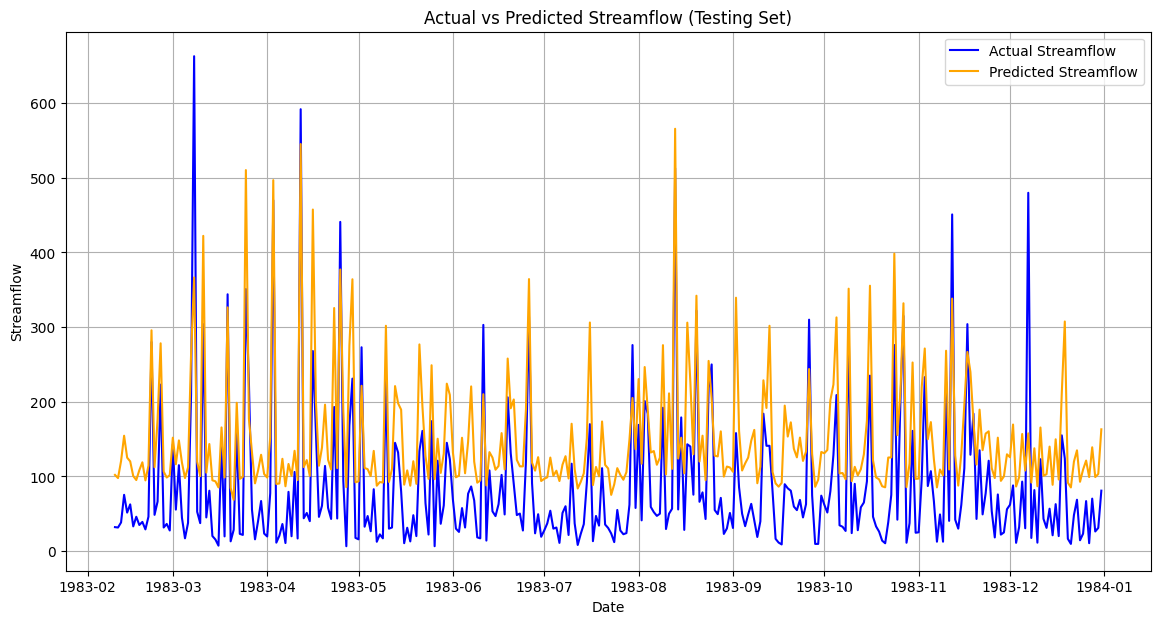

In [13]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(dates[-len(y_test_actual):], y_test_actual, label='Actual Streamflow', color='blue')
plt.plot(dates[-len(y_test_actual):], y_test_pred, label='Predicted Streamflow', color='orange')
plt.title('Actual vs Predicted Streamflow (Testing Set)')
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from tensorflow.keras.layers import (
    LayerNormalization, MultiHeadAttention, Add, Dense, Dropout, Flatten, Input
)
from tensorflow.keras.models import Model

# Transformer Encoder Function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])  # Residual connection

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])  # Residual connection

# Build Model Function
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)  # Output layer for regression
    return Model(inputs, outputs)

# Example Usage
input_shape = X_train.shape[1:]  # Replace X_train with your training data
model = build_model(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.1,
    mlp_dropout=0.1,
)

# Compile and summarize the model
model.compile(loss="mse", optimizer="adam")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 16)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 1, 16)          │             32 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 16)          │         68,624 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 16)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 16)          │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 1, 16)          │             32 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 1, 4)           │             68 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 4)           │              0 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 1, 16)          │             80 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1, 16)          │              0 │ dense_54[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 1, 16)          │             32 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 16)          │         68,624 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 16)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 16)          │              0 │ dropout_4[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_20    │ (None, 1, 16)          │             32 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 277,681 (1.06 MB)

 Trainable params: 277,681 (1.06 MB)

 Non-trainable params: 0 (0.00 B)